In [7]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# There are multiple genres per movie
df = pd.read_csv("dataset/movies_metadata.csv",usecols=['genres', 'overview'])
# Convert genres string type to list
df['genres'] = df['genres'].apply(lambda x: literal_eval(x)).apply(lambda x: sorted([d['name'] for d in x]))
df.head()

print(f"There are {len(df)} rows in the dataset.")

# Some movies have no overview, remove them
print(df['overview'].isnull().sum())
df = df.dropna(subset = ['overview']).reset_index(drop=True)

total_duplicate_titles = sum(df["overview"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

df = df[~df["overview"].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

df['genres_str'] = df['genres'].apply(lambda x: " ".join(str(s) for s in x))

# There are some genres combinations with occurrence as low as 1.
print(sum(df["genres_str"].value_counts() == 1))

# How many unique terms?
print(df["genres_str"].nunique())

# Remove movies with very short overviews
df_filtered = df[df["overview"].apply(lambda x: len(x.split(" "))) > 3]

# Filtering the rare genres combination
df_filtered = df_filtered.groupby("genres_str").filter(lambda x: len(x) > 1)[['overview', 'genres']]
df_filtered.shape

# Remove movies with no genres
df_filtered = df_filtered[df_filtered['genres'].apply(lambda x: len(x)) > 0]

genres = []
for x in df_filtered['genres']:
    if len(x) > 0:
        genres.extend(x)
pd.Series(genres).value_counts()

test_split = 0.2

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["genres"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

genres = tf.ragged.constant(train_df["genres"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot", num_oov_indices=0)
lookup.adapt(genres)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

sample_label = train_df["genres"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

label_decoded = invert_multi_hot(label_binarized[0])
print(f"Decoded binarized label representation: {label_decoded}")

print(train_df["overview"].apply(lambda x: len(x.split(" "))).describe())

There are 45466 rows in the dataset.
954
There are 205 duplicate titles.
There are 44307 rows in the deduplicated dataset.
848
1910
Number of rows in training set: 33022
Number of rows in validation set: 4128
Number of rows in test set: 4128
Vocabulary:

['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Documentary', 'Adventure', 'Science Fiction', 'Family', 'Mystery', 'Fantasy', 'Animation', 'Music', 'Foreign', 'History', 'War', 'Western', 'TV Movie']
Original label: ['Comedy', 'Drama', 'Mystery']
Label-binarized representation: [[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Decoded binarized label representation: ['Drama' 'Comedy' 'Mystery']
count    33022.000000
mean        55.436981
std         34.647556
min          4.000000
25%         28.000000
50%         48.000000
75%         73.000000
max        187.000000
Name: overview, dtype: float64


In [52]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["genres"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["overview"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

vocabulary = set()
train_df["overview"].str.lower().str.replace('[^\w\s]','').str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=None, output_mode="tf_idf")

# text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=None, output_mode="count")

# text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, output_sequence_length=max_seqlen, output_mode="int")

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text, label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text, label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text, label), num_parallel_calls=auto
).prefetch(auto)

def make_model():
    model = keras.Sequential(
        [
            tf.keras.Input(shape=(1,), dtype=tf.string, name='text'),
            text_vectorizer,
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return model

130373


Epoch 1/2
258/258 [==============================] - 22s 82ms/step - loss: 0.2323 - binary_accuracy: 0.9148 - categorical_accuracy: 0.5170 - accuracy: 0.0000e+00 - auc_4: 0.8741 - f1_score: 0.2692 - precision_4: 0.6588 - recall_4: 0.3789 - val_loss: 0.1980 - val_binary_accuracy: 0.9231 - val_categorical_accuracy: 0.5317 - val_accuracy: 0.0000e+00 - val_auc_4: 0.9125 - val_f1_score: 0.3162 - val_precision_4: 0.7160 - val_recall_4: 0.4240
Epoch 2/2
258/258 [==============================] - 21s 81ms/step - loss: 0.0728 - binary_accuracy: 0.9716 - categorical_accuracy: 0.5928 - accuracy: 9.7511e-04 - auc_4: 0.9904 - f1_score: 0.5444 - precision_4: 0.9048 - recall_4: 0.8133 - val_loss: 0.2667 - val_binary_accuracy: 0.9157 - val_categorical_accuracy: 0.4668 - val_accuracy: 2.5436e-04 - val_auc_4: 0.8837 - val_f1_score: 0.3333 - val_precision_4: 0.6189 - val_recall_4: 0.4797


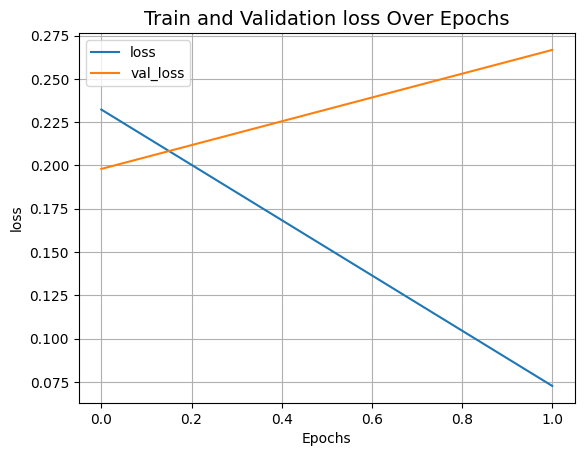

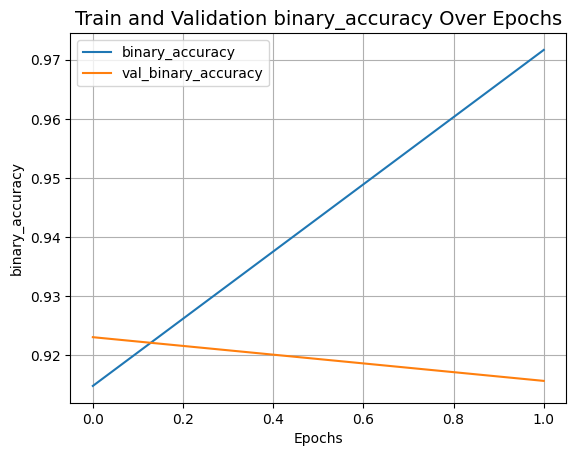

In [55]:
epochs = 2

# model = make_model()

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(text_vectorizer)
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(lookup.vocabulary_size(), activation="sigmoid"))

model.compile(
    loss="binary_crossentropy", 
    optimizer="adam",
    # metrics=[tf.keras.metrics.BinaryAccuracy()],
    metrics=[tf.keras.metrics.BinaryAccuracy(), 
             tf.keras.metrics.CategoricalAccuracy(), 
             tf.keras.metrics.Accuracy(), 
             tf.keras.metrics.AUC(), 
             tf.keras.metrics.F1Score(average='macro'), 
             tf.keras.metrics.Precision(), 
             tf.keras.metrics.Recall()]
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping_monitor]
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [84]:
# Create a model for inference.
model_for_inference = keras.Sequential([model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

4/4 [==============================] - 0s 14ms/step


In [57]:
text_batch

<tf.Tensor: shape=(100,), dtype=string, numpy=
array([b"Nikolai, a Russian hit-man escapes from his adversaries into the streets of Los Angeles. He is taken into the household of Lesley and her son Johnny. In exchange for refuge, Nikolai repairs the single mother's decaying house and symbolically mends fences between everyday people of Russia and the U.S. When enemies get too close to his new home, Nikolai makes his escape to Montana.",
       b'Neal Cassady is living the beat life during the 1940s, working at The Tire Yard and and philandering around town. However, he has visions of a happy life with kids and a white picket fence. When his girlfried, Joan, tries to kill herself he gets scared and runs away. But when Joan reappears will he take the chance at that happiness, or will he turn his back on it?',
       b"A secret organisation offers wealthy people a second chance at life. The customer picks out someone they want to be and the organisation surgically alters the customer to l

In [88]:
text_batch, label_batch = next(iter(train_dataset))
text_batch.shape
a = text_batch.numpy()

In [90]:
a[0]

b'In the year 2159, two classes of people exist: the very wealthy who live on a pristine man-made space station called Elysium, and the rest, who live on an overpopulated, ruined Earth. Secretary Rhodes (Jodie Foster), a hard line government of\xef\xac\x81cial, will stop at nothing to enforce anti-immigration laws and preserve the luxurious lifestyle of the citizens of Elysium. That doesn\xe2\x80\x99t stop the people of Earth from trying to get in, by any means they can. When unlucky Max (Matt Damon) is backed into a corner, he agrees to take on a daunting mission that, if successful, will not only save his life, but could bring equality to these polarized worlds.'

In [ ]:
'In the year 2159, two classes of people exist: the very wealthy who live on a pristine man-made space station called Elysium, and the rest, who live on an overpopulated, ruined Earth. Secretary Rhodes (Jodie Foster), a hard line government of\xef\xac\x81cial, will stop at nothing to enforce anti-immigration laws and preserve the luxurious lifestyle of the citizens of Elysium. That doesn\xe2\x80\x99t stop the people of Earth from trying to get in, by any means they can. When unlucky Max (Matt Damon) is backed into a corner, he agrees to take on a daunting mission that, if successful, will not only save his life, but could bring equality to these polarized worlds.'

In [82]:
# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b"Nikolai, a Russian hit-man escapes from his adversaries into the streets of Los Angeles. He is taken into the household of Lesley and her son Johnny. In exchange for refuge, Nikolai repairs the single mother's decaying house and symbolically mends fences between everyday people of Russia and the U.S. When enemies get too close to his new home, Nikolai makes his escape to Montana."
Label(s): ['Drama' 'Action' 'Crime' 'Adventure']
Predicted Label(s): (Drama, Action, Romance)
 
Abstract: b'Neal Cassady is living the beat life during the 1940s, working at The Tire Yard and and philandering around town. However, he has visions of a happy life with kids and a white picket fence. When his girlfried, Joan, tries to kill herself he gets scared and runs away. But when Joan reappears will he take the chance at that happiness, or will he turn his back on it?'
Label(s): ['Drama']
Predicted Label(s): (Drama, Comedy, Family)
 
Abstract: b"A secret organisation offers wealthy people a seco

In [58]:
str_input = text_batch[0].numpy().decode()

In [59]:
str_input

"Nikolai, a Russian hit-man escapes from his adversaries into the streets of Los Angeles. He is taken into the household of Lesley and her son Johnny. In exchange for refuge, Nikolai repairs the single mother's decaying house and symbolically mends fences between everyday people of Russia and the U.S. When enemies get too close to his new home, Nikolai makes his escape to Montana."

In [81]:
text_batch[0]

<tf.Tensor: shape=(), dtype=string, numpy=b"Nikolai, a Russian hit-man escapes from his adversaries into the streets of Los Angeles. He is taken into the household of Lesley and her son Johnny. In exchange for refuge, Nikolai repairs the single mother's decaying house and symbolically mends fences between everyday people of Russia and the U.S. When enemies get too close to his new home, Nikolai makes his escape to Montana.">

In [39]:
text_vectorizer(text_batch).shape

TensorShape([100, 79206])

In [37]:
vectorized_input = text_vectorizer([str_input])

In [38]:
vectorized_input.shape

TensorShape([1, 79206])

In [62]:
model.predict([str_input])

1/1 [==============================] - 0s 78ms/step


array([[6.9201446e-01, 6.6896982e-02, 1.0240780e-01, 1.4563560e-01,
        6.0845476e-01, 1.9382467e-04, 2.2115275e-01, 2.5197235e-04,
        8.5799061e-02, 8.6511258e-04, 4.4573317e-03, 3.7102746e-03,
        1.7735198e-03, 9.1952825e-04, 1.8394006e-03, 2.7052637e-02,
        5.6543937e-03, 1.1926141e-03, 7.9426402e-04, 4.2253011e-03]],
      dtype=float32)

In [70]:
@tf.function
def inference_function(text):
  # model_inputs = text_vectorizer(text)

  # inference model
  model_outputs = model([text])

  # outputs = # do some post-processing with starts, ends, and model_outputs
  return model_outputs


import os
model_dir = "models/"
model_name = "model"
model_version = "1"
model_export_path = f"{model_dir}/{model_name}/{model_version}"

model.save(
  filepath=model_export_path,
  signatures={
    "serving_default": inference_function.get_concrete_function(tf.TensorSpec([None], dtype=tf.string)),
  }
)

INFO:tensorflow:Assets written to: models//model/1/assets


INFO:tensorflow:Assets written to: models//model/1/assets


In [86]:
import os
model_dir = "models/"
model_name = "model"
model_version = "1"
model_export_path = f"{model_dir}/{model_name}/{model_version}"

sess = tf.Session()
sess.run(tf.global_variables_initializer())
builder = tf.saved_model.builder.SavedModelBuilder(model_export_path)
builder.add_meta_graph_and_variables(
    sess, [tf.compat.v1.saved_model.tag_constants.SERVING],
    signature_def_map={
        'serving_default':
            inference_function.get_concrete_function(tf.TensorSpec([None], dtype=tf.string)),
    },
    main_op=tf.compat.v1.tables_initializer(),
    strip_default_attrs=True)
builder.save()
sess.close()
tf.reset_default_graph()

AttributeError: module 'tensorflow' has no attribute 'Session'

In [71]:
loaded_model = tf.saved_model.load(model_export_path)


In [80]:
loaded_model.signatures['serving_default'](["test"])

TypeError: Binding inputs to tf.function `signature_wrapper` failed due to `too many positional arguments`. Received args: (['test'],) and kwargs: {} for signature: (*, text: TensorSpec(shape=(None,), dtype=tf.string, name='text')).

In [ ]:
import os
model_dir = "models/"
model_name = "model"
model_version = "1"
model_export_path = f"{model_dir}/{model_name}/{model_version}"

tf.saved_model.save(
    model,
    export_dir=model_export_path,
    signatures={
    "inference_fn": inference_function.get_concrete_function(tf.TensorSpec([None], dtype=tf.string)),
  }
)

print(f"SavedModel files: {os.listdir(model_export_path)}")

In [92]:
import os
model_dir = "models/"
model_name = "model"
model_version = "1"
model_export_path = f"{model_dir}/{model_name}/{model_version}"

tf.saved_model.save(
    model,
    export_dir=model_export_path,
)

print(f"SavedModel files: {os.listdir(model_export_path)}")

INFO:tensorflow:Assets written to: models//model/1/assets


INFO:tensorflow:Assets written to: models//model/1/assets


SavedModel files: ['fingerprint.pb', 'keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']


In [94]:
model.predict(['In the year 2159, two classes of people exist: the very wealthy who live on a pristine man-made space station called Elysium, and the rest, who live on an overpopulated, ruined Earth. Secretary Rhodes (Jodie Foster), a hard line government of\xef\xac\x81cial, will stop at nothing to enforce anti-immigration laws and preserve the luxurious lifestyle of the citizens of Elysium. That doesn\xe2\x80\x99t stop the people of Earth from trying to get in, by any means they can. When unlucky Max (Matt Damon) is backed into a corner, he agrees to take on a daunting mission that, if successful, will not only save his life, but could bring equality to these polarized worlds.'])

1/1 [==============================] - 0s 29ms/step


array([[1.7864062e-01, 4.2842832e-01, 1.4679827e-01, 1.9784946e-02,
        3.1964073e-01, 1.7340910e-02, 2.2075791e-02, 3.9340057e-03,
        1.9291231e-01, 9.2264676e-01, 4.4833627e-02, 7.1314489e-03,
        2.3493510e-02, 7.4275605e-02, 6.7116460e-04, 2.8097962e-03,
        5.9919775e-04, 3.6852024e-04, 1.5874910e-04, 1.5589758e-02]],
      dtype=float32)